In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
from numpy import random
from numpy.random import rand, randint, ranf, randn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
import cv2

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)

In [3]:
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

In [4]:
from centernet.utils import preprocess_image, get_mask_and_regr
from centernet.utils import CarDataset

BATCH_SIZE = 16

img_name = train_list[8]
img_path = PATH + "image_2/" + img_name + ".png"
img = plt.imread(img_path)
img, offset, scale = preprocess_image(img,True)
mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, annotations_list, offset, scale)

train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# DL Model

In [5]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from centernet.models import MyUNet

## MyUNetの出力ベクトル長を設定
model = MyUNet(26).to(device)

def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=3,
                              verbose=True
                             )
    return optimizer, scheduler

Loaded pretrained weights for efficientnet-b0


# Training

In [7]:
#from centernet.models import train_model, evaluate_model
from centernet.models import criterion

In [8]:
def train_model(epoch, history=None):
    model.train()
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)\
            in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_size_batch = regr_size_batch.to(device)
        regr_3D_batch = regr_3D_batch.to(device)
        mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        mask_loss, regr_size_loss, regr_3D_loss =\
            criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
        loss = mask_loss + regr_size_loss + regr_3D_loss
        loss.backward()
        optimizer.step()
            
        train_mask_loss += mask_loss.detach()
        train_regr_size_loss += regr_size_loss.detach()
        train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_dataset)
    train_regr_size_loss /= len(train_dataset)
    train_regr_3D_loss /= len(train_dataset)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'train_mask_loss'] = train_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_size_loss'] = train_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_3D_loss'] = train_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'train_loss'] = train_loss.data.cpu().numpy()
        
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        train_loss))

def evaluate_model(epoch, history=None):
    model.eval()
    val_mask_loss = 0
    val_regr_size_loss = 0
    val_regr_3D_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)
            mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)

            output = model(img_batch)

            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
                    
            val_mask_loss += mask_loss.detach()
            val_regr_size_loss += regr_size_loss.detach()
            val_regr_3D_loss += regr_3D_loss.detach()
    
    val_mask_loss /= len(val_dataset)
    val_regr_size_loss /= len(val_dataset)
    val_regr_3D_loss /= len(val_dataset)
    val_loss = val_mask_loss + val_regr_size_loss + val_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'val_mask_loss'] = val_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_size_loss'] = val_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_3D_loss'] = val_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'val_loss'] = val_loss.data.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))
    
    scheduler.step(val_loss)

In [9]:
def setSeed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)

In [10]:
n_epochs = 50
FINE_TUNE_EPOCH = 30
val_loss_min = np.Inf
history = pd.DataFrame()


def train(epoch, val_loss_min):
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    if history['val_loss'][epoch] < val_loss_min:
        val_loss_min = history['val_loss'][epoch]
        torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')
        model_cpu = model.to('cpu')
        torch.save(model_cpu.state_dict(), '../models/model_cpu_' + str(epoch) + '.pth')
    return val_loss_min

setSeed(0)
print("Base model parameters are FREEZED.")
for param in model.base_model.parameters():
    param.requires_grad = False
optimizer, scheduler = setOptimizer(0.01)
for epoch in range(FINE_TUNE_EPOCH):
    val_loss_min = train(epoch, val_loss_min)

print("Base model parameters are UNFREEZED.")
for param in model.base_model.parameters():
    param.requires_grad = True
optimizer, scheduler = setOptimizer(0.001)
for epoch in range(FINE_TUNE_EPOCH,n_epochs):
    val_loss_min = train(epoch, val_loss_min)

  0%|          | 0/445 [00:00<?, ?it/s]

Base model parameters are FREEZED.


100%|██████████| 445/445 [09:34<00:00,  1.29s/it]

Train Epoch: 0 	LR: 0.010000	Loss: 27.828371


Val loss: 18.7341


100%|██████████| 445/445 [09:32<00:00,  1.29s/it]

Train Epoch: 1 	LR: 0.010000	Loss: 19.914639


Val loss: 18.0908


100%|██████████| 445/445 [09:22<00:00,  1.26s/it]

Train Epoch: 2 	LR: 0.010000	Loss: 19.254524


Val loss: 15.4005


100%|██████████| 445/445 [09:12<00:00,  1.24s/it]

Train Epoch: 3 	LR: 0.010000	Loss: 18.176693



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 15.5388


100%|██████████| 445/445 [09:05<00:00,  1.23s/it]

Train Epoch: 4 	LR: 0.010000	Loss: 17.538855


Val loss: 14.2083


100%|██████████| 445/445 [09:39<00:00,  1.30s/it]

Train Epoch: 5 	LR: 0.010000	Loss: 17.441050


Val loss: 13.3602


100%|██████████| 445/445 [09:21<00:00,  1.26s/it]

Train Epoch: 6 	LR: 0.010000	Loss: 17.576372


Val loss: 12.7513


100%|██████████| 445/445 [09:25<00:00,  1.27s/it]

Train Epoch: 7 	LR: 0.010000	Loss: 16.673813



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 14.7111


100%|██████████| 445/445 [09:14<00:00,  1.25s/it]

Train Epoch: 8 	LR: 0.010000	Loss: 15.776566



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.1723


100%|██████████| 445/445 [09:19<00:00,  1.26s/it]

Train Epoch: 9 	LR: 0.010000	Loss: 16.305162


Val loss: 12.6087


100%|██████████| 445/445 [09:25<00:00,  1.27s/it]

Train Epoch: 10 	LR: 0.010000	Loss: 15.126501



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.6137


100%|██████████| 445/445 [09:02<00:00,  1.22s/it]

Train Epoch: 11 	LR: 0.010000	Loss: 15.682491


Val loss: 11.9891


100%|██████████| 445/445 [09:29<00:00,  1.28s/it]

Train Epoch: 12 	LR: 0.010000	Loss: 16.139202



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.3736


100%|██████████| 445/445 [09:00<00:00,  1.22s/it]

Train Epoch: 13 	LR: 0.010000	Loss: 14.778833



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.8495


100%|██████████| 445/445 [09:06<00:00,  1.23s/it]

Train Epoch: 14 	LR: 0.010000	Loss: 15.067118


Val loss: 11.6746


100%|██████████| 445/445 [08:55<00:00,  1.20s/it]

Train Epoch: 15 	LR: 0.010000	Loss: 14.513245



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.0133


100%|██████████| 445/445 [09:16<00:00,  1.25s/it]

Train Epoch: 16 	LR: 0.010000	Loss: 14.733965



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.8695


100%|██████████| 445/445 [09:16<00:00,  1.25s/it]

Train Epoch: 17 	LR: 0.010000	Loss: 14.553858



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.1509


100%|██████████| 445/445 [09:00<00:00,  1.22s/it]

Train Epoch: 18 	LR: 0.010000	Loss: 15.154274


Val loss: 11.4580


100%|██████████| 445/445 [09:26<00:00,  1.27s/it]

Train Epoch: 19 	LR: 0.010000	Loss: 15.573772



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.4855


100%|██████████| 445/445 [09:13<00:00,  1.24s/it]

Train Epoch: 20 	LR: 0.010000	Loss: 14.217729



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.6166


100%|██████████| 445/445 [09:00<00:00,  1.22s/it]

Train Epoch: 21 	LR: 0.010000	Loss: 14.943441



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.4610


100%|██████████| 445/445 [09:11<00:00,  1.24s/it]

Train Epoch: 22 	LR: 0.010000	Loss: 14.201181


Val loss: 11.2865


100%|██████████| 445/445 [08:53<00:00,  1.20s/it]

Train Epoch: 23 	LR: 0.010000	Loss: 14.949424



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.8778


100%|██████████| 445/445 [08:58<00:00,  1.21s/it]

Train Epoch: 24 	LR: 0.010000	Loss: 14.861670


Val loss: 10.7320


100%|██████████| 445/445 [08:59<00:00,  1.21s/it]

Train Epoch: 25 	LR: 0.010000	Loss: 14.692065



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.0732


100%|██████████| 445/445 [09:17<00:00,  1.25s/it]

Train Epoch: 26 	LR: 0.010000	Loss: 13.984184



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.1961


100%|██████████| 445/445 [09:02<00:00,  1.22s/it]

Train Epoch: 27 	LR: 0.010000	Loss: 13.825281



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.5006


100%|██████████| 445/445 [09:12<00:00,  1.24s/it]

Train Epoch: 28 	LR: 0.010000	Loss: 15.094363



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.0580
Epoch    29: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 445/445 [09:19<00:00,  1.26s/it]

Train Epoch: 29 	LR: 0.001000	Loss: 13.749660


Val loss: 10.6151


  0%|          | 0/445 [00:00<?, ?it/s]

Base model parameters are UNFREEZED.


100%|██████████| 445/445 [17:59<00:00,  2.43s/it]

Train Epoch: 30 	LR: 0.001000	Loss: 13.592464



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 13.1597


100%|██████████| 445/445 [18:08<00:00,  2.45s/it]

Train Epoch: 31 	LR: 0.001000	Loss: 13.190441



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5939


100%|██████████| 445/445 [18:19<00:00,  2.47s/it]

Train Epoch: 32 	LR: 0.001000	Loss: 14.712952



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.9445


100%|██████████| 445/445 [17:47<00:00,  2.40s/it]

Train Epoch: 33 	LR: 0.001000	Loss: 13.314734



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5888


100%|██████████| 445/445 [18:05<00:00,  2.44s/it]

Train Epoch: 34 	LR: 0.001000	Loss: 14.163116



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.0092


100%|██████████| 445/445 [18:04<00:00,  2.44s/it]

Train Epoch: 35 	LR: 0.001000	Loss: 13.381246



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.1843


100%|██████████| 445/445 [17:57<00:00,  2.42s/it]

Train Epoch: 36 	LR: 0.001000	Loss: 14.117098



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.3651


100%|██████████| 445/445 [18:05<00:00,  2.44s/it]

Train Epoch: 37 	LR: 0.001000	Loss: 13.754879



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5372


100%|██████████| 445/445 [18:15<00:00,  2.46s/it]

Train Epoch: 38 	LR: 0.001000	Loss: 14.046833



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.9598


100%|██████████| 445/445 [17:53<00:00,  2.41s/it]

Train Epoch: 39 	LR: 0.001000	Loss: 13.665865


Val loss: 10.1189


100%|██████████| 445/445 [18:01<00:00,  2.43s/it]

Train Epoch: 40 	LR: 0.001000	Loss: 12.812353



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.5471


100%|██████████| 445/445 [17:58<00:00,  2.42s/it]

Train Epoch: 41 	LR: 0.001000	Loss: 13.216589



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 9.7638


100%|██████████| 445/445 [17:58<00:00,  2.42s/it]

Train Epoch: 42 	LR: 0.001000	Loss: 12.772233



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2001


100%|██████████| 445/445 [17:59<00:00,  2.43s/it]

Train Epoch: 43 	LR: 0.001000	Loss: 13.864569



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.3250


100%|██████████| 445/445 [18:11<00:00,  2.45s/it]

Train Epoch: 44 	LR: 0.001000	Loss: 13.334704



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 9.6579


100%|██████████| 445/445 [18:29<00:00,  2.49s/it]

Train Epoch: 45 	LR: 0.001000	Loss: 12.711451



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.8548


100%|██████████| 445/445 [19:04<00:00,  2.57s/it]

Train Epoch: 46 	LR: 0.001000	Loss: 12.701889



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 10.2580


100%|██████████| 445/445 [18:07<00:00,  2.44s/it]

Train Epoch: 47 	LR: 0.001000	Loss: 13.970697



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 12.2087


100%|██████████| 445/445 [18:52<00:00,  2.55s/it]

Train Epoch: 48 	LR: 0.001000	Loss: 12.351918



  0%|          | 0/445 [00:00<?, ?it/s]

Val loss: 11.7507
Epoch    19: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 445/445 [19:25<00:00,  2.62s/it]

Train Epoch: 49 	LR: 0.000100	Loss: 12.622675


Val loss: 11.2611


In [11]:
#model = MyUNet(26)
#model.eval()
#if torch.cuda.is_available():
#    model_path = "../models/model_28.pth"
#else:
#    model_path = "../models/model_cpu_28.pth"
#m_state_dict = torch.load(model_path)
#model.load_state_dict(m_state_dict)

In [12]:
#n_epochs = 50
#FINE_TUNE_EPOCH = 30
#val_loss_min = np.Inf
#history = pd.DataFrame()
#
#
#def train(epoch, val_loss_min):
#    torch.cuda.empty_cache()
#    gc.collect()
#    train_model(epoch, history)
#    evaluate_model(epoch, history)
#    if history['train_loss'][epoch] < val_loss_min:
#        val_loss_min = history['train_loss'][epoch]
#        torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')
#        model_cpu = model.to('cpu')
#        torch.save(model_cpu.state_dict(), '../models/model_cpu_' + str(epoch) + '.pth')
#    return val_loss_min
#
#setSeed(0)
#print("Base model parameters are FREEZED.")
#for param in model.base_model.parameters():
#    param.requires_grad = False
#optimizer, scheduler = setOptimizer(0.1)
#for epoch in range(28,FINE_TUNE_EPOCH):
#    val_loss_min = train(epoch, val_loss_min)
#
#print("Base model parameters are UNFREEZED.")
#for param in model.base_model.parameters():
#    param.requires_grad = True
#optimizer, scheduler = setOptimizer(0.001)
#for epoch in range(FINE_TUNE_EPOCH,n_epochs):
#    val_loss_min = train(epoch, val_loss_min)

In [13]:
torch.save(model.state_dict(), '../models/model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), '../models/model_cpu.pth')

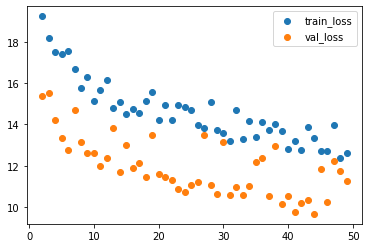

In [14]:
train_loss = history.dropna()['train_loss']
val_loss = history.dropna()['val_loss']
plt.scatter(train_loss.index[2:], train_loss[2:])
plt.scatter(val_loss.index[2:], val_loss[2:])
plt.legend(["train_loss", "val_loss"])

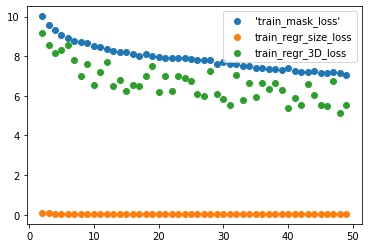

In [15]:
train_mask_loss = history.dropna()['train_mask_loss']
train_regr_size_loss = history.dropna()['train_regr_size_loss']
train_regr_3D_loss = history.dropna()['train_regr_3D_loss']
plt.scatter(train_loss.index[2:], train_mask_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_size_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_3D_loss[2:])
plt.legend(["'train_mask_loss'", "train_regr_size_loss", "train_regr_3D_loss"])

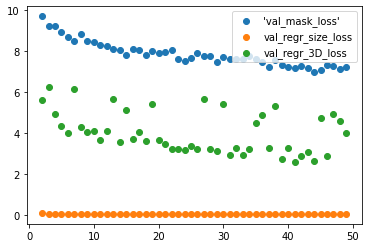

In [16]:
val_mask_loss = history.dropna()['val_mask_loss']
val_regr_size_loss = history.dropna()['val_regr_size_loss']
val_regr_3D_loss = history.dropna()['val_regr_3D_loss']
plt.scatter(val_loss.index[2:], val_mask_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_size_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_3D_loss[2:])
plt.legend(["'val_mask_loss'", "val_regr_size_loss", "val_regr_3D_loss"])

In [17]:
torch.cuda.empty_cache()
gc.collect()

0

# Check result

In [18]:
m = MyUNet(26)
m.eval()
m_state_dict = torch.load("../models/model.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [19]:
img, mask, regr, cnr, regr_cnr = val_dataset[0]
output = m(torch.tensor(img[None]).to(device))
output = output.data.cpu().numpy()

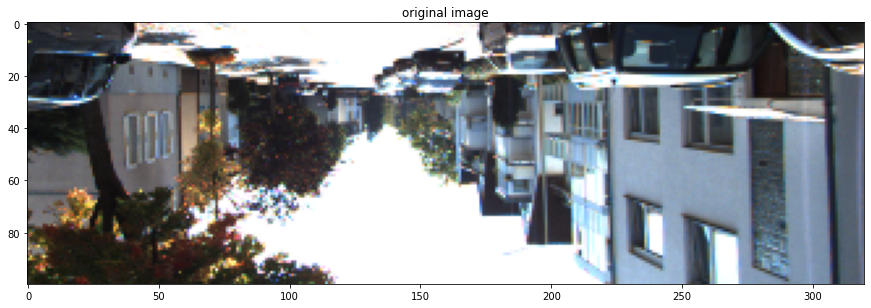

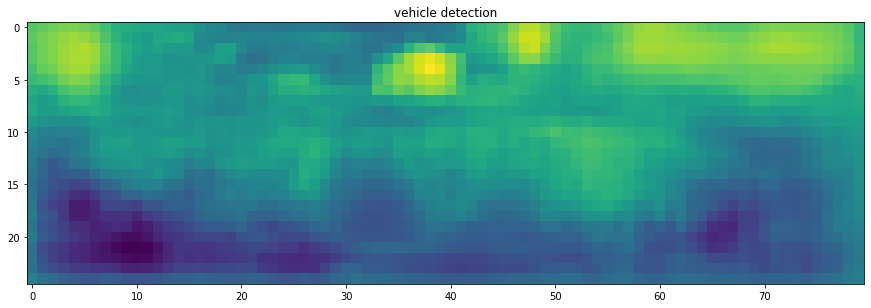

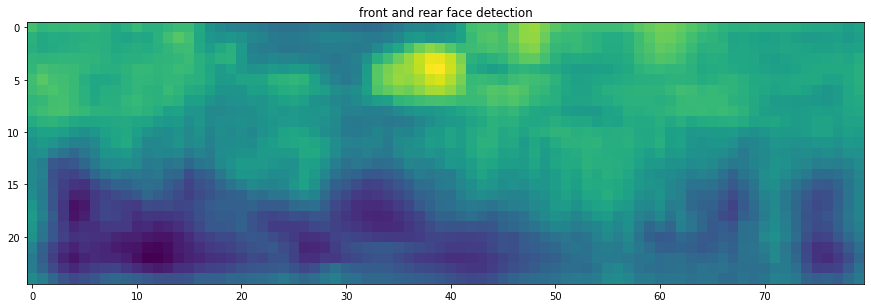

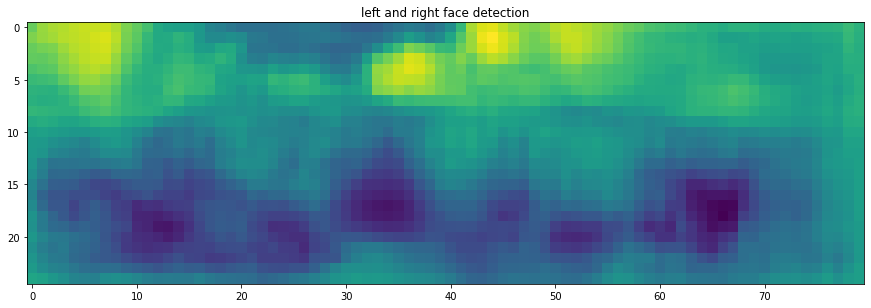

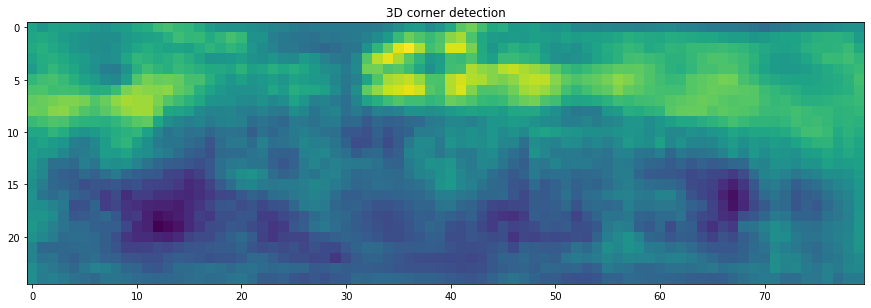

In [20]:
plt.figure(figsize=(15,8))
plt.title('original image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.figure(figsize=(15,8))
plt.title('vehicle detection')
plt.imshow(output[0,0])
plt.figure(figsize=(15,8))
plt.title('front and rear face detection')
plt.imshow(output[0,1])
plt.figure(figsize=(15,8))
plt.title('left and right face detection')
plt.imshow(output[0,2])
plt.figure(figsize=(15,8))
plt.title('3D corner detection')
plt.imshow(output[0,3])

## inference test

In [21]:
from centernet.utils import inference_heatmap, inference_2D, inference_3D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


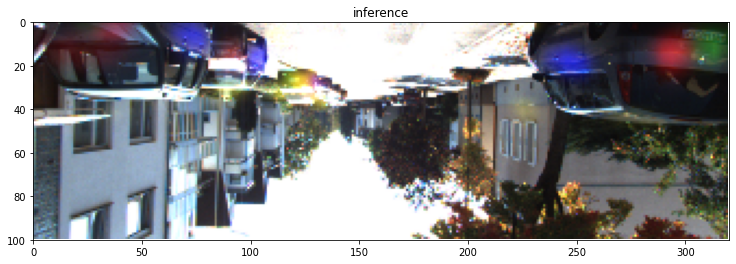

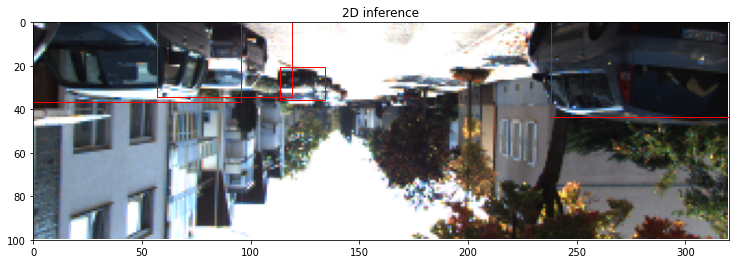

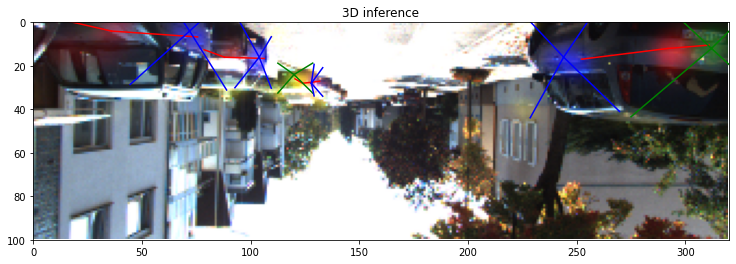

In [22]:
img, _, _, _, _ = val_dataset[0]

inference_heatmap(model, img)
inference_2D(model, img)
inference_3D(model, img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


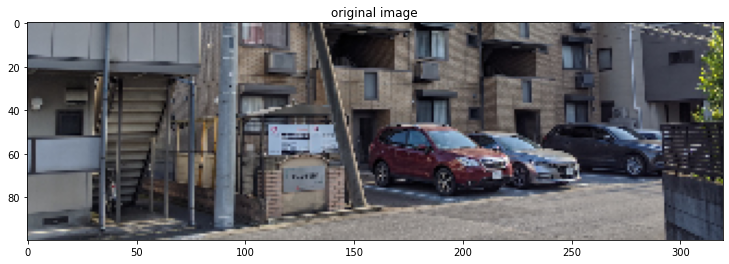

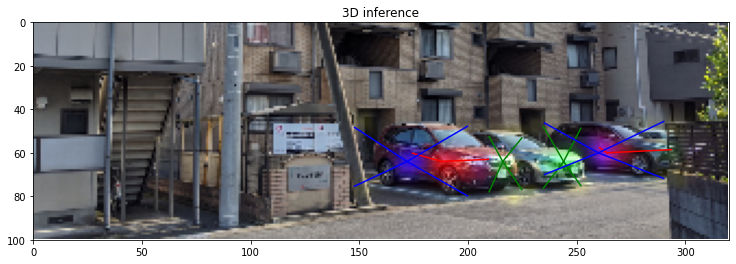

In [24]:
path = "../tmp/4.jpg"
img = plt.imread(path)
img = cv2.resize(img, (1280//4, 400//4))
img = img
plt.figure(figsize=(15,4))
plt.title('original image')
plt.imshow(img)
img = np.rollaxis(img/255, 2, 0).astype('float32')

output = model(torch.tensor(img[None]).to(device))
logits = output.data.cpu().numpy()

inference_3D(model, img)